### Import

In [11]:
# Libraries
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import random

# Files
from vehicle import *
from plotting import *
from simulate import *
from mpc import *
 

### Simulation Input Parameters

In [12]:
#### MPC Properties
dt = 0.5                  # Time step [s]
N = 20                 # Time Horizon

####  Simulation/Problem Parameters
pos_constraints = [0, 40, 0, 20]         # Position Constraints [m]:    [x_min, x_max, y_min, y_max]
x_init = np.array([2, 10, 0, 0])         # Initial State: [x, y, x_dot, y_dot]
x_target = np.array([40, 10, 0, 0])      # Target State: [x, y, x_dot, y_dot]
T = 75                                   # Simulation time [s]           


# Obstacle Definition: list[] obstacle = [center_x, center_y, radius]
obstacles = [[random.randint(8, 30), random.randint(0, 20), random.randint(0, 4)],
             [random.randint(8, 30), random.randint(0, 20), random.randint(0, 4)],
             [random.randint(8, 30), random.randint(0, 20), random.randint(0, 4)],
             [random.randint(8, 30), random.randint(0, 20), random.randint(0, 4)],
             [random.randint(8, 30), random.randint(0, 20), random.randint(0, 4)],
             [random.randint(8, 30), random.randint(0, 20), random.randint(0, 4)]]

# Moving Obstacle Definition: list[] moving_obstacle = [center_x, center_y, vel_x, vel_y, radius]  
move_obstacles = [[30, 20, 0, -0.2, 4]]

#### Drone Velocity & Acceleration Constraints
vel_constraints = [-0.5, 0.5, -0.5, 0.5]         # Velocity Constraints [m/s]:  [x_min, x_max, y_min, y_max] 
acc_constraints = [-1, 1, -1, 1]         # Acceleration Constraints [m/s^2]:    [x_min, x_max, y_min, y_max] 

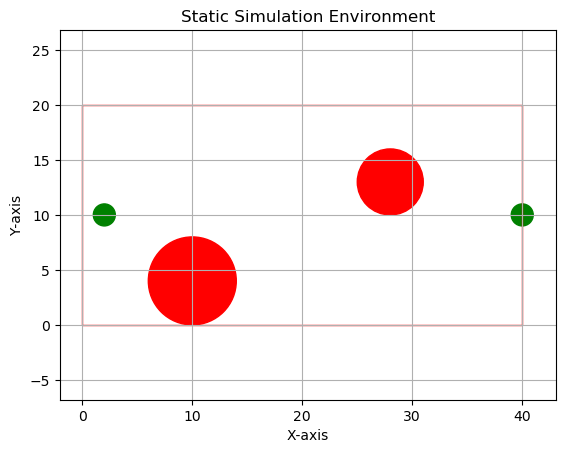

In [13]:
# Plot the static Obstacles
plot_static_obstacles(obstacles, pos_constraints, x_init, x_target)

In [14]:
# %%capture
# Setup vehichle & controller then Simulate
vehicle = vehicle_SS(dt)
controller = lambda x_init, move_obstacles, initial_guess_x : mpc_control(vehicle, N, x_init, x_target, pos_constraints, vel_constraints, acc_constraints, obstacles, move_obstacles, initial_guess_x)
states, inputs, plans, timesteps = simulate(dt, T, x_init, N, controller, move_obstacles, num_states=len(x_init), num_inputs=2)

Timesteps: 150
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 567.00us ( 13.50us) 573.68us ( 13.66us)        42
       nlp_g  |   1.06ms ( 25.33us)   1.03ms ( 24.60us)        42
  nlp_grad_f  | 893.00us ( 20.77us) 893.93us ( 20.79us)        43
  nlp_hess_l  |   4.78ms (116.49us)   4.79ms (116.73us)        41
   nlp_jac_g  |   4.82ms (112.02us)   4.84ms (112.62us)        43
       total  |  83.90ms ( 83.90ms)  83.79ms ( 83.79ms)         1
Optimal cost: 26872.959063589464
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 177.00us ( 16.09us) 174.33us ( 15.85us)        11
       nlp_g  | 318.00us ( 28.91us) 311.21us ( 28.29us)        11
  nlp_grad_f  | 287.00us ( 23.92us) 286.91us ( 23.91us)        12
  nlp_hess_l  |   1.26ms (126.20us)   1.26ms (126.34us)        10
   nlp_jac_g  |   1.50ms (125.33us)   1.51ms (125.73us)        12
       total  |  24.89ms ( 24.89ms)  24.90ms ( 24.90ms)         1
Optimal cost: 26517.03974047

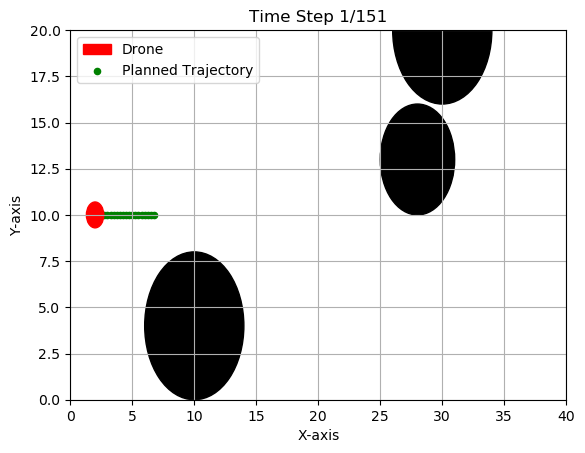

In [15]:
def update(frame):
    # Clear previous frame
    plt.cla()

    move_obstacles_update = MovingObstacleConvert(move_obstacles, frame, dt)
    
    # Plot Path for current state
    plt.scatter(plans[0][:, frame], plans[1][:, frame], c='g', s=20, label = "Planned Trajectory")

    # Plot current state
    drone = plt.Circle((states[0][frame], states[1][frame]), 0.7, color='r', fill=True, label = "Drone")
    plt.gca().add_patch(drone)
    
    for obstacle in obstacles:
        circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='k', fill=True)
        plt.gca().add_patch(circle) 

    for obstacle in move_obstacles_update:
        circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='k', fill=True)
        plt.gca().add_patch(circle) 


    plt.legend()
    plt.title(f'Time Step {frame + 1}/{len(states[1])}')  # Set title for each frame
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.xlim(pos_constraints[0], pos_constraints[1])
    plt.ylim(pos_constraints[2], pos_constraints[3])
    plt.grid()

# Create the animation
fig = plt.figure()
ani = FuncAnimation(fig, update, frames=len(states[1]), interval=50)

# Display the animation within the Jupyter Notebook using HTML
HTML(ani.to_jshtml())
